In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sentence_transformers

# 라이브러리, 함수

In [58]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import norm
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request

from sentence_transformers import SentenceTransformer
from imblearn.over_sampling import SMOTE
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from keras.models import load_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import warnings

import joblib

warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):

    data, sample_rate = librosa.load(path, duration=2.5, offset=0.0)

    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.concatenate((result, res2), axis = 0)

    # # data with stretching and pitching
    # new_data = stretch(data)
    # data_stretch_pitch = pitch(new_data, sample_rate)
    # res3 = extract_features(data_stretch_pitch, sample_rate)
    # result = np.concatenate((result, res3), axis = 0)

    return result

In [5]:
class text_embedding():
  def __init__(self, model_name):
    self.model_name = model_name

  def fit(self, X, y=None):
        return self

  def transform(self, X):
        embedding_model = SentenceTransformer(self.model_name)
        embedding_vec = embedding_model.encode(X['sentence'])
        X_val = np.concatenate((X.drop(['sentence', 'final_label', 'wav_id'], axis = 1), embedding_vec), axis = 1)
        return X_val


class text_embedding2():
  def __init__(self, model_name):
    self.model_name = model_name

  def fit(self, X, y=None):
        return self

  def transform(self, X):
        embedding_model = SentenceTransformer(self.model_name)
        embedding_vec = embedding_model.encode(X['sentence'])
        X_val = np.concatenate((X.drop(['sentence', 'output_관점변화', 'output_부정', 'output_인정',
       'output_존중', 'output_피드백', 'output'], axis = 1), embedding_vec), axis = 1)
        return X_val

In [6]:
def custom_model1(x_train):
  model=Sequential()
  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  model.add(Dropout(0.2))

  model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Flatten())
  model.add(Dense(units=32, activation='relu'))
  model.add(Dropout(0.3))

  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

  return model

In [7]:
def custom_model2(x_train):
  model=Sequential()
  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  model.add(Dropout(0.2))

  model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Flatten())
  model.add(Dense(units=32, activation='relu'))
  model.add(Dropout(0.3))

  model.add(Dense(units=5, activation='softmax'))
  model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

  return model

In [8]:
def learning_curve(history, epoch):
  # 정확도 차트
  plt.figure(figsize = (10, 5))  # 차트 크기 조절을 위함

  epoch_range = np.arange(1, epoch + 1)

  plt.subplot(1, 2, 1)

  # history는 fit 결과값을 저장하는 변수
  # accuracy 차트
  plt.plot( epoch_range, history.history["accuracy"])
  plt.plot( epoch_range, history.history["val_accuracy"])
  plt.title("Model Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accurach")
  plt.legend( ["Train", "Val"] )


  # loss 차트
  plt.figure(figsize = (10, 5))

  plt.subplot(1, 2, 2)

  plt.plot( epoch_range, history.history["loss"])
  plt.plot( epoch_range, history.history["val_loss"])
  plt.title("Model Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend( ["Train", "Val"] )

  plt.show()

# 데이터 불러오기

In [62]:
grow_csv = pd.read_csv("/content/drive/MyDrive/aihub/grow_0620_녹음필요.csv", encoding= 'CP949')
print(f"grow_data 길이: {len(grow_csv)}")
print(f"grow_data shape: {grow_csv.shape}")

grow_data 길이: 621
grow_data shape: (621, 4)


In [63]:
grow_csv.columns = ['sentence', 'label', 'output', 'wav_id']
grow_data = grow_csv.drop(['label'], axis=1)
grow_data.head()

,sentence,output,wav_id
0,당신의 목표는 무엇입니까?,관점변화,test_0
1,왜 이 목표를 달성하고 싶습니까?,관점변화,test_1
2,이 목표를 달성하면 어떤 이점이 있나요?,관점변화,test_2
3,무엇을 달성하고 싶나요?,관점변화,test_3
4,당신은 정말로 무엇을 원하십니까?,관점변화,test_4


In [64]:
output = ['관점변화', '부정', '인정', '존중', '피드백']
encoder = LabelEncoder()

encoder.fit(output)
output_labels = encoder.transform(grow_data['output'])

In [65]:
final_df = pd.get_dummies(grow_data, columns = ['output'])
final_df['output'] = output_labels
final_df.head()

,sentence,wav_id,output_관점변화,output_부정,output_인정,output_존중,output_피드백,output
0,당신의 목표는 무엇입니까?,test_0,1,0,0,0,0,0
1,왜 이 목표를 달성하고 싶습니까?,test_1,1,0,0,0,0,0
2,이 목표를 달성하면 어떤 이점이 있나요?,test_2,1,0,0,0,0,0
3,무엇을 달성하고 싶나요?,test_3,1,0,0,0,0,0
4,당신은 정말로 무엇을 원하십니까?,test_4,1,0,0,0,0,0


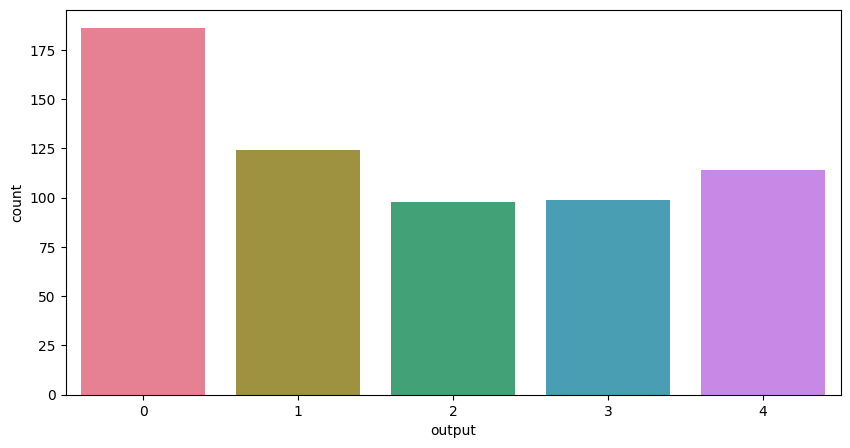

In [66]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x = final_df['output'], palette = "husl",  ax = ax)
plt.show()

# 음성 긍부정

In [94]:
grow_path = '/content/drive/MyDrive/aihub/grow_wav'

In [95]:
gwav_df = pd.DataFrame(
    {'wav_id': grow_csv['wav_id'],
     'final_label': grow_csv['label'],
     'sentence': grow_csv['sentence']
    })
gwav_df.head(3)

,wav_id,final_label,sentence
0,test_0,0,당신의 목표는 무엇입니까?
1,test_1,0,왜 이 목표를 달성하고 싶습니까?
2,test_2,0,이 목표를 달성하면 어떤 이점이 있나요?


In [ ]:
# filename=gwav_df['wav_id'][10]+'.wav'
# path = '/content/drive/MyDrive/aihub/grow_wav/'+filename

# emotion = gwav_df['final_label'][1]
# data, sampling_rate = librosa.load(path)
# create_waveplot(data, sampling_rate, emotion)
# create_spectrogram(data, sampling_rate, emotion)
# Audio(path)

In [ ]:
# filename=gwav_df['wav_id'][10]+'.wav'
# path = '/content/drive/MyDrive/aihub/grow_wav/'+filename
# data, sample_rate = librosa.load(path)

In [ ]:
# x = noise(data)
# plt.figure(figsize=(14,4))
# librosa.display.waveshow(y=x, sr=sample_rate)
# Audio(x, rate=sample_rate)

In [ ]:
# x = shift(data)
# plt.figure(figsize=(14,4))
# librosa.display.waveshow(y=x, sr=sample_rate)
# Audio(x, rate=sample_rate)

In [96]:
X_audio, Y = [], []
for path, label in zip(gwav_df['wav_id'], gwav_df['final_label']):
    audio_features = get_features(grow_path+'/'+path+'.wav') #
    X_audio.append(audio_features)
    Y.append(label)

audio_features = pd.DataFrame(X_audio)
gfinal_df = pd.concat([audio_features, gwav_df[['wav_id', 'final_label', 'sentence']]], axis = 1)
gfinal_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,317,318,319,320,321,322,323,wav_id,final_label,sentence
0,0.072786,0.576298,0.526643,0.534596,0.530564,0.526582,0.500360,0.470907,0.513745,0.532623,...,0.000587,0.000609,0.000550,0.000577,0.000560,0.000578,0.000590,test_0,0,당신의 목표는 무엇입니까?
1,0.091720,0.516270,0.496700,0.483967,0.487830,0.492909,0.473973,0.494775,0.549668,0.564156,...,0.003317,0.003144,0.003310,0.003182,0.003274,0.003186,0.003223,test_1,0,왜 이 목표를 달성하고 싶습니까?
2,0.069377,0.560717,0.574552,0.526369,0.497562,0.471308,0.424226,0.411417,0.460032,0.522805,...,0.000402,0.000400,0.000358,0.000372,0.000367,0.000369,0.000375,test_2,0,이 목표를 달성하면 어떤 이점이 있나요?


In [97]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001) #learning rate 조절

In [98]:
class text_embedding():
  def __init__(self, model_name):
    self.model_name = model_name

  def fit(self, X, y=None):
        return self

  def transform(self, X):
        embedding_model = SentenceTransformer(self.model_name)
        embedding_vec = embedding_model.encode(X['sentence'])
        X_val = np.concatenate((X.drop(['sentence', 'final_label', 'wav_id'], axis = 1), embedding_vec), axis = 1)
        return X_val

In [99]:
Y = gfinal_df['final_label'].values

txt_embed = text_embedding(model_name = 'jhgan/ko-sroberta-multitask')
X = txt_embed.transform(gfinal_df)

x_train_, x_test_, y_train_, y_test = train_test_split(pd.DataFrame(X), Y, test_size=0.1, random_state=0, stratify=Y)
# pd.DataFrame(x_train_).reset_index(drop=True).to_csv('230628_voice_df.csv', index=False)

train_index = x_train_.index.values
test_index = x_test_.index.values

scaler = StandardScaler()
scaler.fit(x_train_)

StandardScaler()

In [100]:
# scale_file_name = '230628_voice_scaler.pkl'
joblib.dump(scaler, open('230628_voice_scaler.pkl', 'wb'))

(558,) -> (894,)
Epoch 1/50
14/14 [==============================] - 40s 3s/step - loss: 0.6910 - accuracy: 0.5358 - val_loss: 0.6420 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 42s 3s/step - loss: 0.6297 - accuracy: 0.6521 - val_loss: 0.5920 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 37s 3s/step - loss: 0.4628 - accuracy: 0.7841 - val_loss: 0.4054 - val_accuracy: 0.8413 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 40s 3s/step - loss: 0.3460 - accuracy: 0.8389 - val_loss: 0.2408 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 37s 3s/step - loss: 0.3015 - accuracy: 0.8725 - val_loss: 0.2759 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 42s 3s/step - loss: 0.2504 - accuracy: 0.8949 - val_loss: 0.1586 - val_accuracy: 0.9365 - lr: 0.0010
Epoch 7/50
14/14 [==============================] - 37s 3s/step -

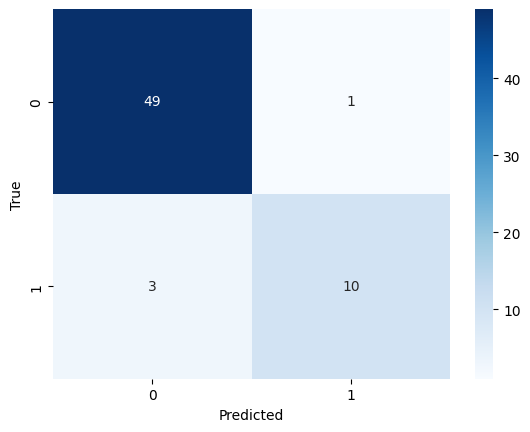

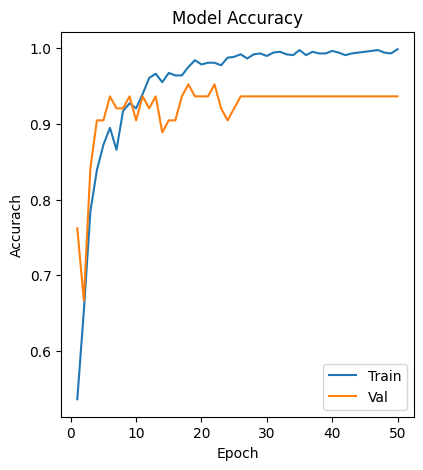

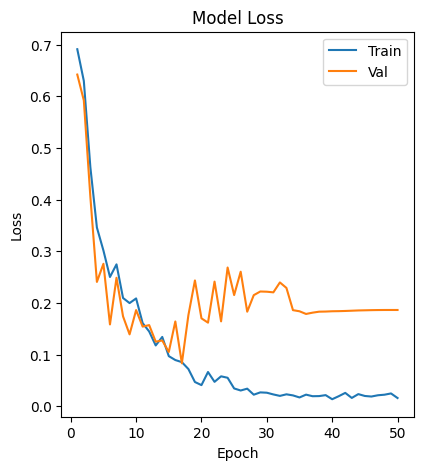

In [27]:
x_train_ = scaler.transform(x_train_)
x_test = scaler.transform(x_test_)

sm = SMOTE()
x_train, y_train = sm.fit_resample(x_train_, y_train_)
print(y_train_.shape, '->', y_train.shape)

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

model = custom_model1(x_train)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Pre-trained Model: ", 'jhgan/ko-sroberta-multitask')
print("Test Accuracy: ",test_acc)


pred = model.predict(x_test)
print(classification_report(y_test, pred.round()))

cm = confusion_matrix(y_test, pred.round())
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

learning_curve(history, 50)


model.save('/content/drive/MyDrive/aihub/data/230628_voice_model1.h5')



# 텍스트 긍부정

In [101]:
grow_data = pd.read_csv("/content/drive/MyDrive/aihub/grow_0620_녹음필요.csv", encoding= 'CP949')
print(f"grow_data 길이: {len(grow_data)}")
print(f"grow_data shape: {grow_data.shape}")

grow_data 길이: 621
grow_data shape: (621, 4)


In [102]:
grow_data.columns = ['sentence', 'label', 'output', '파일명']
grow_data = grow_data.drop(['label', '파일명'], axis=1)
grow_data

,sentence,output
0,당신의 목표는 무엇입니까?,관점변화
1,왜 이 목표를 달성하고 싶습니까?,관점변화
2,이 목표를 달성하면 어떤 이점이 있나요?,관점변화
3,무엇을 달성하고 싶나요?,관점변화
4,당신은 정말로 무엇을 원하십니까?,관점변화
...,...,...
616,안녕하세요.,존중
617,반갑습니다.,존중
618,반가워요.,존중
619,에이블님 안녕하세요.,존중


In [103]:
output = ['관점변화', '부정', '인정', '존중', '피드백']
encoder = LabelEncoder()

encoder.fit(output)
output_labels = encoder.transform(grow_data['output'])

final_df = pd.get_dummies(grow_data, columns = ['output'])
final_df['output'] = output_labels

In [104]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001) #learning rate 조절


In [105]:
txt_embed = text_embedding2(model_name = 'jhgan/ko-sroberta-multitask')
X = txt_embed.transform(final_df)

Y = final_df['output_부정'].values
x_train_, x_test_, y_train_, y_test = train_test_split(pd.DataFrame(X), Y, test_size=0.1, random_state=0, stratify=Y)
# pd.DataFrame(x_train_).reset_index(drop=True).to_csv('230628_text_df.csv', index=False)

In [107]:
scaler = StandardScaler()
scaler.fit(x_train_)

joblib.dump(scaler, open('230628_text_scaler.pkl', 'wb'))

(558,) -> (894,)
Epoch 1/50
14/14 [==============================] - 29s 2s/step - loss: 0.7283 - accuracy: 0.5134 - val_loss: 0.6323 - val_accuracy: 0.7937 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 30s 2s/step - loss: 0.6973 - accuracy: 0.5045 - val_loss: 0.6853 - val_accuracy: 0.7937 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 28s 2s/step - loss: 0.6805 - accuracy: 0.5761 - val_loss: 0.6396 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 28s 2s/step - loss: 0.5809 - accuracy: 0.7081 - val_loss: 0.5578 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 28s 2s/step - loss: 0.5037 - accuracy: 0.7595 - val_loss: 0.4402 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 26s 2s/step - loss: 0.4395 - accuracy: 0.7987 - val_loss: 0.3825 - val_accuracy: 0.8413 - lr: 0.0010
Epoch 7/50
14/14 [==============================] - 28s 2s/step -

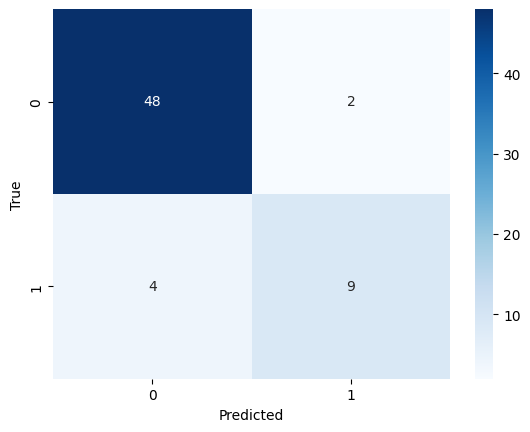

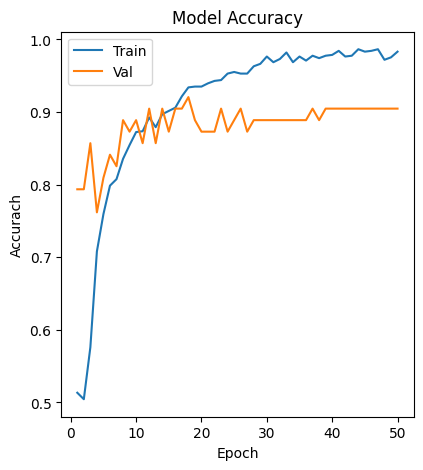

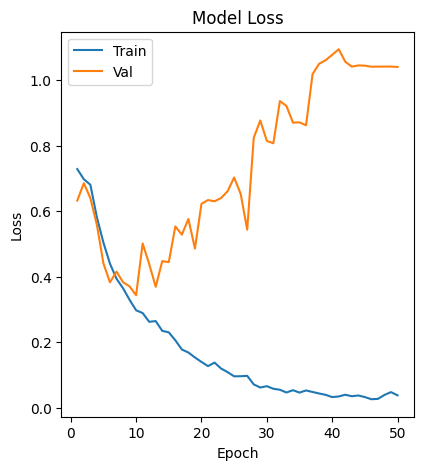

In [33]:
x_train_ = scaler.transform(x_train_)
x_test = scaler.transform(x_test_)

sm = SMOTE()
x_train, y_train = sm.fit_resample(x_train_, y_train_)
print(y_train_.shape, '->', y_train.shape)

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

model = custom_model1(x_train)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Pre-trained Model: ", 'jhgan/ko-sroberta-multitask')
print("Test Accuracy: ",test_acc)


pred = model.predict(x_test)
print(classification_report(y_test, pred.round()))

cm = confusion_matrix(y_test, pred.round())
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

learning_curve(history, 50)

model.save('/content/drive/MyDrive/aihub/data/230628_text_model1.h5')

In [ ]:
x_train_, x_test_, y_train_, y_test = train_test_split(pd.DataFrame(X), Y, test_size=0.1, random_state=0, stratify=Y)


In [50]:
pd.DataFrame(x_train_)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-1.320739,-0.579156,-1.914172,-0.548398,0.455353,1.214291,0.193062,1.316043,-1.328810,-0.608905,...,2.451515,-0.836875,-0.435108,-1.236311,0.735483,1.714990,0.496811,1.450115,0.445007,0.802703
1,0.343532,0.661008,0.912702,-0.332808,0.036343,-1.575822,-0.201059,-0.886651,1.315620,-0.547800,...,1.951547,1.373602,1.031440,1.014989,-1.263461,0.267471,0.536503,0.893224,-0.266248,-1.387240
2,1.506079,-0.742559,-0.539600,0.229353,1.414742,-1.452818,0.277451,-0.903371,-0.954725,1.825760,...,-0.312554,-1.473019,-0.146767,1.435471,0.921728,0.212633,0.003516,1.073815,-0.203932,-0.348529
3,-0.301613,0.794846,-1.111182,-0.696823,0.738532,-0.246920,1.096213,-0.634448,1.889672,-0.134545,...,0.336532,0.429476,0.636360,-0.095330,0.203084,-0.448538,0.565937,-0.408511,0.782225,-0.463778
4,1.468755,-0.401379,0.678385,-1.103813,-0.249825,0.545384,-0.946159,0.764310,0.272854,0.262903,...,-0.869489,-0.786172,0.901529,-0.585923,-0.995872,-0.010171,-0.673658,-0.963603,-0.033764,0.221703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,-0.331198,2.469731,-0.263598,-0.482952,1.833769,2.215510,0.296792,-1.692404,-0.947321,-0.175370,...,-1.187650,0.553018,0.704035,1.582040,0.651966,-1.545151,-0.493454,-1.059636,0.180515,-0.317725
554,-2.846587,-0.266115,-0.752812,-0.507412,1.022288,-0.133597,1.343746,-0.157427,-0.165058,-1.077666,...,-0.882792,-0.280311,0.096495,1.084777,0.245872,1.120518,0.277193,1.580933,-0.508986,0.141526
555,-0.742894,-0.200846,1.423026,-1.601631,1.188109,0.890308,-0.657846,0.505143,1.060712,-0.632993,...,-0.123802,0.210338,0.910737,0.327492,-0.729474,-0.997902,0.410741,0.534076,0.916741,-0.964350
556,1.756029,-1.763972,-0.862630,1.184101,-0.007022,0.759228,-2.600010,1.277600,0.499761,-1.425680,...,0.593087,-0.939814,0.392793,-0.748769,-0.760930,-0.823662,0.854193,0.173490,1.194607,0.328620


# 2차 분류

In [51]:
res1 = pd.DataFrame(pred.round(), columns=['pred1'])
res1['output'] = final_df.loc[test_index]['output'].reset_index(drop=True)
res1_df = pd.concat([x_test_.reset_index(drop=True), res1], axis=1)
# res1_df.head()

# cols = [x for x in range(324)]
# res1_df = res1_df.drop(cols, axis=1)

test_set2 = res1_df.loc[(res1_df['pred1']==0)]
x_test_2 = test_set2.drop(['pred1', 'output'], axis=1)

train2_df = final_df.loc[final_df['output']!=1].reset_index(drop=True)

(497,) -> (744,)
Epoch 1/50
12/12 [==============================] - 26s 2s/step - loss: 1.4937 - accuracy: 0.2581 - val_loss: 1.5509 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 21s 2s/step - loss: 1.4600 - accuracy: 0.2500 - val_loss: 1.5726 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 24s 2s/step - loss: 1.4496 - accuracy: 0.2433 - val_loss: 1.5522 - val_accuracy: 0.2308 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 22s 2s/step - loss: 1.4392 - accuracy: 0.2473 - val_loss: 1.5558 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - 26s 2s/step - loss: 1.4135 - accuracy: 0.2769 - val_loss: 1.5341 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - 21s 2s/step - loss: 1.3842 - accuracy: 0.2997 - val_loss: 1.5034 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 7/50
12/12 [==============================] - 24s 2s/step -

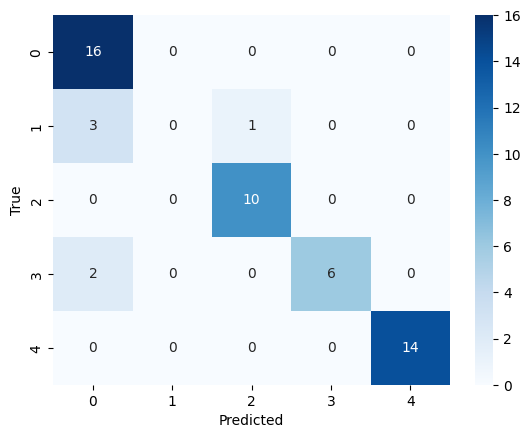

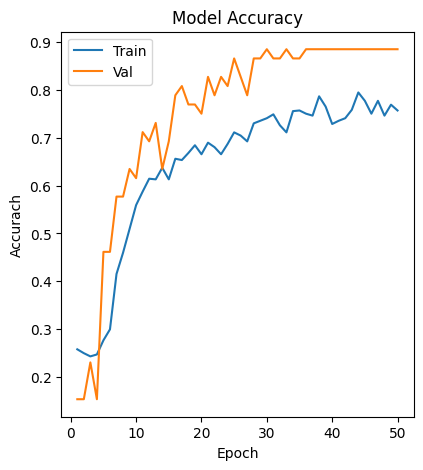

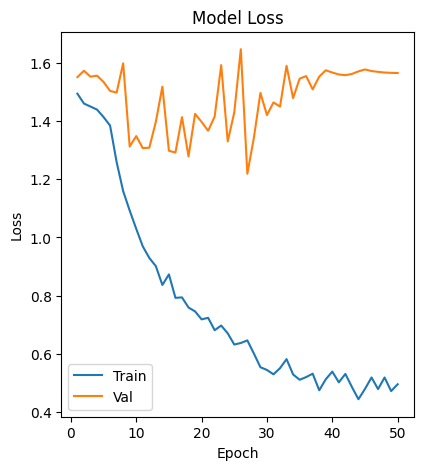

In [54]:
# 2차분류
txt_embed = text_embedding2(model_name = 'jhgan/ko-sroberta-multitask')
x_train_2_ = txt_embed.transform(train2_df)

x_train_2 = scaler.fit_transform(x_train_2_)
x_test2 = scaler.transform(x_test_2)

y_train_2 = train2_df['output']
y_test2 = test_set2['output']

sm = SMOTE()
x_train2, y_train2 = sm.fit_resample(x_train_2, y_train_2)
print(y_train_2.shape, '->', y_train2.shape)

x_train2 = np.expand_dims(x_train2, axis=2)
x_test2 = np.expand_dims(x_test2, axis=2)
x_train2.shape, y_train2.shape, x_test2.shape, y_test2.shape

model = custom_model2(x_train2)

history=model.fit(x_train2, y_train2, batch_size=64, epochs=50, validation_data=(x_test2, y_test2), callbacks=[rlrp])

test_loss, test_acc = model.evaluate(x_test2, y_test2, verbose=0)
print("Pre-trained Model: ", 'jhgan/ko-sroberta-multitask')
print("Test Accuracy: ",test_acc)

pred2 = model.predict(x_test2)
predic2 = np.argmax(pred2, axis=1)
print(classification_report(y_test2, predic2))

cm2 = confusion_matrix(y_test2, predic2)
sns.heatmap(cm2, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

learning_curve(history, 50)


model.save('/content/drive/MyDrive/aihub/data/230628_result_model2.h5')

              precision    recall  f1-score   support

           0       0.76      0.89      0.82        18
           1       0.82      0.69      0.75        13
           2       0.91      1.00      0.95        10
           3       1.00      0.75      0.86         8
           4       1.00      1.00      1.00        14

    accuracy                           0.87        63
   macro avg       0.90      0.87      0.88        63
weighted avg       0.88      0.87      0.87        63



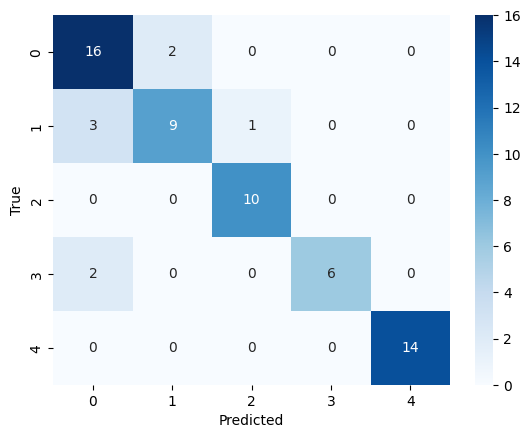

In [55]:
#최종
neg_index = res1_df.loc[(res1_df['pred1']==1)].index.values
pos_index = res1_df.loc[(res1_df['pred1']==0)].index.values

fin_result = pd.DataFrame(final_df.loc[test_index]['sentence']).reset_index(drop=True)

neg_df = fin_result.loc[neg_index]
pos_df = fin_result.loc[pos_index]

neg_df['predict'] = 1
pos_df['predict'] = predic2

final_result = pd.concat([neg_df, pos_df]).sort_index()
final_result['actual'] = final_df.loc[test_index]['output'].reset_index(drop=True)

print(classification_report(final_result['actual'], final_result['predict']))

cm = confusion_matrix(final_result['actual'], final_result['predict'])
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 모델 요약

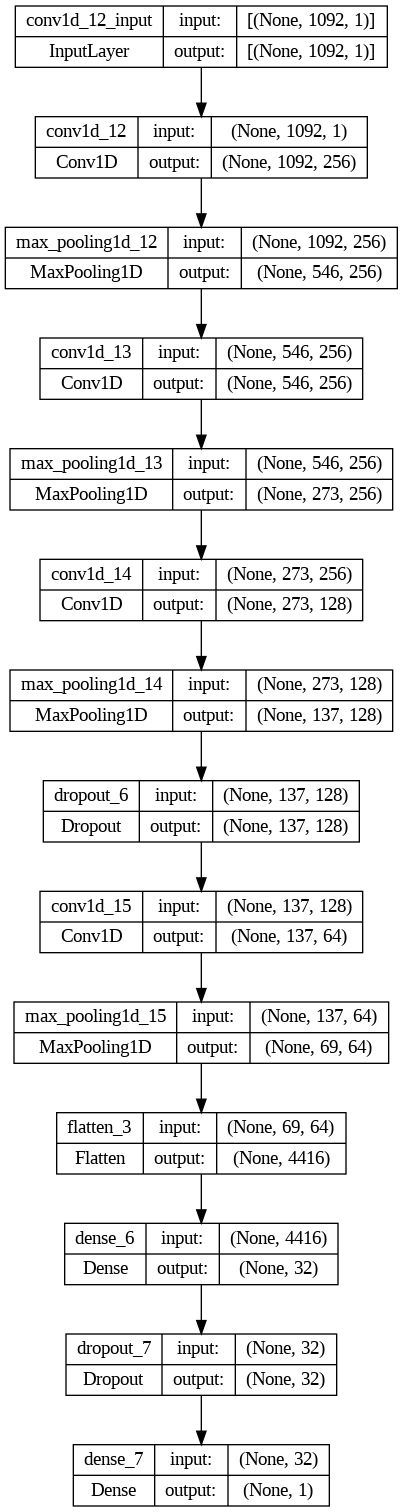

In [ ]:
from tensorflow.keras.utils import plot_model
model = custom_model1(x_train)
plot_model(model, to_file='model1_shapes.png', show_shapes=True)

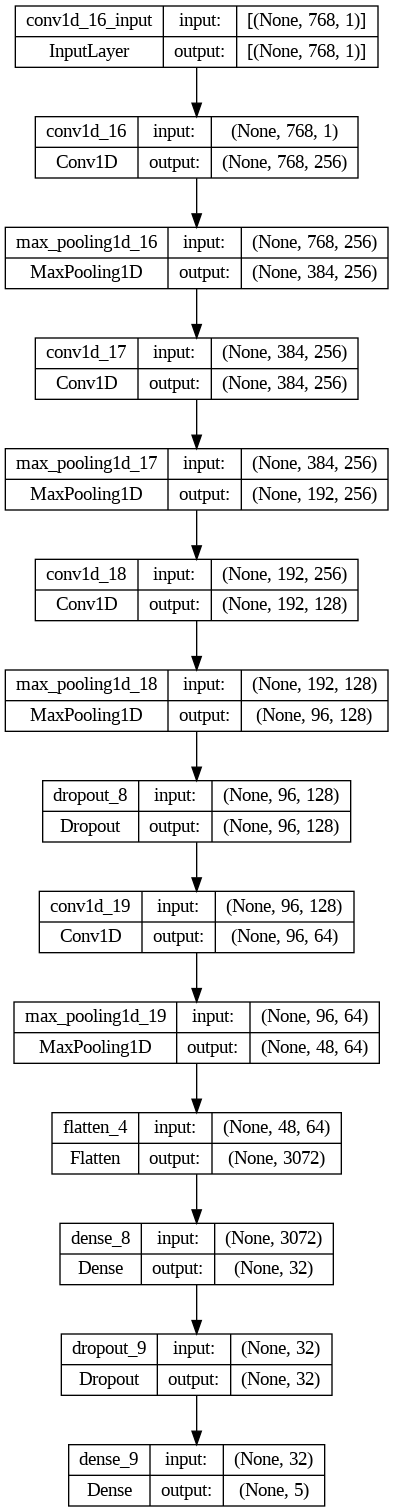

In [ ]:
model = custom_model2(x_train2)
plot_model(model, to_file='model2_shapes.png', show_shapes=True)